# Frame-Level Speech Recognition

We will be working with MFCC data consisting of 27 features at each time step/frame. Our model should be able to recognize the phoneme occured in that frame.

# Libraries

In [ ]:
!pip install torchsummaryX wandb --quiet

In [ ]:
import torch
import numpy as np
from torchsummaryX import summary
import sklearn
import gc
import zipfile
import pandas as pd
from tqdm.auto import tqdm
import os
import datetime
import wandb
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [ ]:
### If you are using colab, you can import google drive to save model checkpoints in a folder
#from google.colab import drive
#drive.mount('/content/idl/models/')

In [ ]:
### PHONEME LIST
PHONEMES = [
            '[SIL]',   'AA',    'AE',    'AH',    'AO',    'AW',    'AY',
            'B',     'CH',    'D',     'DH',    'EH',    'ER',    'EY',
            'F',     'G',     'HH',    'IH',    'IY',    'JH',    'K',
            'L',     'M',     'N',     'NG',    'OW',    'OY',    'P',
            'R',     'S',     'SH',    'T',     'TH',    'UH',    'UW',
            'V',     'W',     'Y',     'Z',     'ZH',    '[SOS]', '[EOS]']

# Kaggle

This section contains code that helps you install kaggle's API, creating kaggle.json with you username and API key details. Make sure to input those in the given code to ensure you can download data from the competition successfully.

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"","key":""}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73248 sha256=a2704ddce65997212cbca09daac32d59d52a8dded8698b9ca1b754a3385fc83a
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [ ]:
# commands to download data from kaggle
!kaggle competitions download -c 11785-hw1p2-s24

!unzip -qo /content/11785-hw1p2-s24.zip -d '/content'

100% 3.73G/3.75G [00:15<00:00, 269MB/s]
100% 3.75G/3.75G [00:15<00:00, 266MB/s]


# Dataset

This section covers the dataset/dataloader class for speech data. You will have to spend time writing code to create this class successfully. We have given you a lot of comments guiding you on what code to write at each stage, from top to bottom of the class. Please try and take your time figuring this out, as it will immensely help in creating dataset/dataloader classes for future homeworks.

Before running the following cells, please take some time to analyse the structure of data. Try loading a single MFCC and its transcipt, print out the shapes and print out the values. Do the transcripts look like phonemes?

In [ ]:
import os
files = os.listdir('../content/11-785-s24-hw1p2/dev-clean/mfcc')
print(f'{len(files)}')

2703


In [ ]:
mfcc = '../content/11-785-s24-hw1p2/dev-clean/mfcc/' + files[1]
tran = '../content/11-785-s24-hw1p2/dev-clean/transcript/' + files[1]
vect = np.load(mfcc)
dat_pad = np.pad(vect, ((5, 5), (0, 0)), mode='constant', constant_values=0)
print(dat_pad[-5:].flatten().shape)
print(vect.shape)
trans = np.load(tran)
print(np.where(np.array(PHONEMES) == 'UH')[0])

(135,)
(915, 27)
[33]


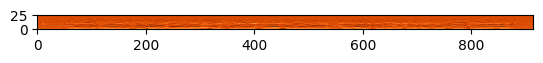

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
mfcc_data= np.swapaxes(vect, 0 ,1)
cax = plt.imshow(mfcc_data, interpolation='nearest', cmap=cm.Oranges_r, origin='lower')
plt.show()

In [ ]:
mfcc = vect
print(vect.shape)
mfcc = ((mfcc) - (np.mean(mfcc, axis=0))) / (np.sqrt(np.var(mfcc, axis=0)))
print(mfcc.shape)
concat = np.concatenate(mfcc, axis=0)
print(concat.shape)

(915, 27)
(915, 27)
(24705,)


In [ ]:
# Dataset class to load train and validation data

class AudioDataset(torch.utils.data.Dataset):

    def __init__(self, root, phonemes = PHONEMES, context=0, partition= "train-clean-100"): # Feel free to add more arguments

        self.context    = context
        self.phonemes   = phonemes

        self.mfcc_dir       = os.path.join(root, partition, 'mfcc')

        self.transcript_dir = os.path.join(root, partition, 'transcript')

        mfcc_names          = sorted(os.listdir(self.mfcc_dir))

        transcript_names    = sorted(os.listdir(self.transcript_dir))

        # Making sure that we have the same no. of mfcc and transcripts
        assert len(mfcc_names) == len(transcript_names)

        self.mfccs, self.transcripts = [], []

        for i in range(len(mfcc_names)):
        #   Load a single mfcc
            mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_names[i]))
        #   Do Cepstral Normalization of mfcc (explained in writeup)
            mfcc = ((mfcc) - (np.mean(mfcc, axis=0))) / (np.std(mfcc, axis=0) + 1e-5)

        #   Load the corresponding transcript
            transcript  = np.load(os.path.join(self.transcript_dir, transcript_names[i]))
        # Remove [SOS] and [EOS] from the transcript
        # (Is there an efficient way to do this without traversing through the transcript?)
        # Note that SOS will always be in the starting and EOS at end, as the name suggests.
            transcript = transcript[1:-1]
        #   Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfcc)
            self.transcripts.append(transcript)

        # NOTE:
        # Each mfcc is of shape T1 x 27, T2 x 27, ...
        # Each transcript is of shape (T1+2) x 27, (T2+2) x 27 before removing [SOS] and [EOS]

        # TODO: Concatenate all mfccs in self.mfccs such that
        # the final shape is T x 27 (Where T = T1 + T2 + ...)
        self.mfccs          = np.concatenate(self.mfccs, axis=0)
        #self.mfccs          = np.vstack(self.mfccs)
        print(f'MFCC shape {self.mfccs.shape} ')

        # TODO: Concatenate all transcripts in self.transcripts such that
        # the final shape is (T,) meaning, each time step has one phoneme output
        self.transcripts    = np.concatenate(self.transcripts, axis=0)
        #self.transcripts    = np.hstack(self.transcripts)
        print(f'Transcripts shape {self.transcripts.shape}')
        # Hint: Use numpy to concatenate

        # Length of the dataset is now the length of concatenated mfccs/transcripts
        self.length = len(self.mfccs)

        # Take some time to think about what we have done.
        # self.mfcc is an array of the format (Frames x Features).
        # Our goal is to recognize phonemes of each frame
        # From hw0, you will be knowing what context is.
        # We can introduce context by padding zeros on top and bottom of self.mfcc
        self.mfccs = np.pad(self.mfccs, ((context, context), (0, 0)), mode='constant', constant_values=0)

        # The available phonemes in the transcript are of string data type
        # But the neural network cannot predict strings as such.
        # Hence, we map these phonemes to integers
        print(f'Check {self.transcripts.shape} and sample {self.transcripts[100]}')
        # TODO: Map the phonemes to their corresponding list indexes in self.phonemes
        self.transcripts = np.array([np.where((np.array(self.phonemes) == trans))[0] for trans in self.transcripts])
        # Now, if an element in self.transcript is 0, it means that it is 'SIL' (as per the above example)
        print(f'Mfccs shape {self.mfccs.shape} and sample {self.mfccs[100]}')
        print(f'Transcripts shape {self.transcripts.shape} and sample {self.transcripts[100]}')

    def __len__(self):
        return self.length

    def __getitem__(self, ind):

        # TODO: Based on context and offset, return a frame at given index with context frames to the left, and right.
        #frames = np.concatenate([self.mfccs[:self.context], self.mfccs[self.context + ind:self.context + ind + 1], self.mfccs[-self.context:]])
        frames = self.mfccs[ind:ind + 2*self.context + 1]
        # After slicing, you get an array of shape ontext2*c+1 x 27. But our MLP needs 1d data and not 2d.
        frames = frames.flatten()

        frames      = torch.FloatTensor(frames) # Convert to tensors
        phonemes    = torch.squeeze(torch.tensor(np.squeeze(self.transcripts[ind])))

        return frames, phonemes

In [ ]:
class AudioTestDataset(torch.utils.data.Dataset):
    def __init__(self, root, context=0, partition= "test-clean"):

        self.context    = context
        self.mfcc_dir       = os.path.join(root, partition, 'mfcc')
        mfcc_names          = sorted(os.listdir(self.mfcc_dir))

        self.mfccs = []

        for i in range(len(mfcc_names)):
        #   Load a single mfcc
            mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_names[i]))
        #   Do Cepstral Normalization of mfcc (explained in writeup)
            mfcc = ((mfcc) - (np.mean(mfcc, axis=0))) / (np.std(mfcc, axis=0) + 1e-5)
            self.mfccs.append(mfcc)

        self.mfccs = np.concatenate(self.mfccs, axis=0)
        self.length = len(self.mfccs)

        # We can introduce context by padding zeros on top and bottom of self.mfcc
        self.mfccs = np.pad(self.mfccs, ((context, context), (0, 0)), mode='constant', constant_values=0)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):

        # TODO: Based on context and offset, return a frame at given index with context frames to the left, and right.
        frames = self.mfccs[ind:ind + 2*self.context + 1]
        # After slicing, you get an array of shape 2*context+1 x 27. But our MLP needs 1d data and not 2d.
        frames = frames.flatten()
        frames = torch.FloatTensor(frames) # Convert to tensors

        return frames

    # TODO: Create a test dataset class similar to the previous class but you dont have transcripts for this
    # Imp: Read the mfccs in sorted order, do NOT shuffle the data here or in your dataloader.

# Parameters Configuration

Storing your parameters and hyperparameters in a single configuration dictionary makes it easier to keep track of them during each experiment. It can also be used with weights and biases to log your parameters for each experiment and keep track of them across multiple experiments.

In [ ]:
config = {
    'epochs'        : 80,
    'batch_size'    : 2048,
    'context'       : 20,
    'init_lr'       : 1e-3,
    'architecture'  : 'high-cutoff'
    # Add more as you need them - e.g dropout values, weight decay, scheduler parameters
}

# Create Datasets

In [ ]:
train_data = AudioDataset(root='../content/11-785-s24-hw1p2/', context=config['context'], partition= "train-clean-100")
print(f'Result Shapes - Data -> {train_data.mfccs.shape} and Labels -> {train_data.transcripts.shape} ')

MFCC shape (36091157, 27) 
Transcripts shape (36091157,)
Check (36091157,) and sample AH
Mfccs shape (36091197, 27) and sample [ 1.7638558e+00  7.6890886e-02 -1.5383435e+00 -1.2271409e-02
 -6.7100900e-01 -3.2965618e-01 -5.9578854e-01 -1.0991193e+00
 -1.8357016e+00  2.9777536e-01 -6.2612665e-01 -1.0256163e-01
 -9.7565281e-01 -7.8316338e-02 -7.6276708e-01 -4.4900739e-01
 -2.8761163e-01 -1.6419492e+00 -1.1264700e+00 -7.9027420e-01
  1.4396261e-01  1.0080085e+00 -1.5419359e+00 -1.7541655e+00
 -2.7218571e-02  5.2518483e-09  2.0897222e-01]
Transcripts shape (36091157, 1) and sample [3]
Result Shapes - Data -> (36091197, 27) and Labels -> (36091157, 1) 


In [ ]:
val_data = AudioDataset('../content/11-785-s24-hw1p2/', context=config['context'], partition= "dev-clean")
print(f'Result Shapes - Data -> {val_data.mfccs.shape} and Labels -> {val_data.transcripts.shape} ')

MFCC shape (1928204, 27) 
Transcripts shape (1928204,)
Check (1928204,) and sample L
Mfccs shape (1928244, 27) and sample [ 1.58368915e-01 -1.21859744e-01  5.12083292e-01  1.15812123e+00
  4.58461791e-01 -3.01561415e-01  2.08318830e-01  7.19309568e-01
  7.96862960e-01 -1.48222816e+00  9.07102302e-02 -2.47009650e-01
  4.21092987e-01 -8.97688940e-02  5.86933732e-01 -4.45923179e-01
  7.59552836e-01  1.40139163e+00 -1.47331461e-01 -7.29686379e-01
  6.72928095e-01 -3.87415558e-01  1.04793763e+00 -5.67102432e-01
  3.70796591e-01 -7.24416482e-09 -8.84944618e-01]
Transcripts shape (1928204, 1) and sample [21]
Result Shapes - Data -> (1928244, 27) and Labels -> (1928204, 1) 


In [ ]:
test_data = AudioTestDataset('../content/11-785-s24-hw1p2/', context=config['context'], partition= "test-clean")
print(f'Result Shapes - Data -> {test_data.mfccs.shape}')

Result Shapes - Data -> (1934178, 27)


In [ ]:
# Define dataloaders for train, val and test datasets
# Dataloaders will yield a batch of frames and phonemes of given batch_size at every iteration
# We shuffle train dataloader but not val & test dataloader. Why?

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = True
)

val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)

test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)


print("Batch size     : ", config['batch_size'])
print("Context        : ", config['context'])
print("Input size     : ", (2*config['context']+1)*27)
print("Output symbols : ", len(PHONEMES))

print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Validation dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size     :  2048
Context        :  20
Input size     :  1107
Output symbols :  42
Train dataset samples = 36091157, batches = 17623
Validation dataset samples = 1928204, batches = 942
Test dataset samples = 1934138, batches = 945


In [ ]:
# Testing code to check if your data loaders are working
for i, data in enumerate(train_loader):
    frames, phoneme = data
    print(frames.shape, phoneme.shape)
    break

torch.Size([2048, 1107]) torch.Size([2048])


In [ ]:
# Testing code to check if your data loaders are working
for i, data in enumerate(val_loader):
    frames, phoneme = data
    print(frames.shape, phoneme.shape)
    break

torch.Size([2048, 1107]) torch.Size([2048])


In [ ]:
for i, data in enumerate(test_loader):
    frames = data
    print(frames.shape)
    break

torch.Size([2048, 1107])


In [ ]:
def init_xavier(m):
  if type(m) == torch.nn.Linear:
    fan_in = m.weight.size()[1]
    fan_out = m.weight.size()[0]
    std = np.sqrt(1.0/(fan_in + fan_out))
    m.weight.data.normal_(0,std)

# Network Architecture


This section defines your network architecture for the homework. We have given you a sample architecture that can easily clear the very low cutoff for the early submission deadline.

In [ ]:
# This architecture will make you cross the very low cutoff
# However, you need to run a lot of experiments to cross the medium or high cutoff
import torch.nn.init as init
class Network(torch.nn.Module):

    def __init__(self, input_size, output_size):

        super(Network, self).__init__()
        layers = []
        k = 15
        size_list = [input_size, 2048, 4096, 2048, 1024, 1024, 512, 512, 256, output_size]
        for i in range(len(size_list)-2):
            linear = torch.nn.Linear(size_list[i],size_list[i+1])
            layers.append(linear)
            init.kaiming_normal_(linear.weight, mode='fan_in')
            layers.append(torch.nn.BatchNorm1d(size_list[i+1]))
            layers.append(torch.nn.GELU())
            layers.append(torch.nn.Dropout(0.30))
        layers.append(torch.nn.Linear(size_list[-2], size_list[-1]))
        self.model = torch.nn.Sequential(*layers)


    def forward(self, x):
        out = self.model(x)

        return out

# Define Model, Loss Function and Optimizer

Here we define the model, loss function, optimizer and optionally a learning rate scheduler.

In [ ]:
INPUT_SIZE  = (2*config['context'] + 1) * 27 # Why is this the case?
model       = Network(INPUT_SIZE, len(val_data.phonemes)).to(device)
summary(model, frames.to(device))
# Check number of parameters of your network
# Remember, you are limited to 24 million parameters for HW1 (including ensembles)

                         Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                    
0_model.Linear_0         [1107, 2048]  [2048, 2048]  2.269184M  2.267136M
1_model.BatchNorm1d_1          [2048]  [2048, 2048]     4.096k     2.048k
2_model.GELU_2                      -  [2048, 2048]          -          -
3_model.Dropout_3                   -  [2048, 2048]          -          -
4_model.Linear_4         [2048, 4096]  [2048, 4096]  8.392704M  8.388608M
5_model.BatchNorm1d_5          [4096]  [2048, 4096]     8.192k     4.096k
6_model.GELU_6                      -  [2048, 4096]          -          -
7_model.Dropout_7                   -  [2048, 4096]          -          -
8_model.Linear_8         [4096, 2048]  [2048, 2048]  8.390656M  8.388608M
9_model.BatchNorm1d_9          [2048]  [2048, 2048]     4.096k     2.048k
10_model.GELU_10                    -  [2048, 2048]          -          -
11_model.Dropout_11                 - 

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_model.Linear_0,"[1107, 2048]","[2048, 2048]",2269184.0,2267136.0
1_model.BatchNorm1d_1,[2048],"[2048, 2048]",4096.0,2048.0
2_model.GELU_2,-,"[2048, 2048]",NaN,NaN
3_model.Dropout_3,-,"[2048, 2048]",NaN,NaN
4_model.Linear_4,"[2048, 4096]","[2048, 4096]",8392704.0,8388608.0
5_model.BatchNorm1d_5,[4096],"[2048, 4096]",8192.0,4096.0
6_model.GELU_6,-,"[2048, 4096]",NaN,NaN
7_model.Dropout_7,-,"[2048, 4096]",NaN,NaN
8_model.Linear_8,"[4096, 2048]","[2048, 2048]",8390656.0,8388608.0


In [ ]:
criterion = torch.nn.CrossEntropyLoss() # Defining Loss function.
# We use CE because the task is multi-class classification
#model.apply(init_xavier)
#optimizer = torch.optim.Adam(model.parameters(), lr= config['init_lr']) #Defining Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.000001)
#optimizer = torch.optim.Adam(model.parameters())
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
 #   factor=0.1, patience=2, verbose=True)

epochs = config['epochs']
total_steps = epochs * len(train_loader)
new_epochs = 10
min_lr = 3.855e-7
#scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=0)
#lr_lambda = lambda epoch: lr + (max_lr - lr) * epoch / 20

# Create the learning rate scheduler
#scheduler = LambdaLR(optimizer, lr_lambda)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=new_epochs)
scheduler.load_state_dict(torch.load("model_checkpoint_high_99.pth"))


# Recommended : Define Scheduler for Learning Rate,
# including but not limited to StepLR, MultiStepLR, CosineAnnealingLR, ReduceLROnPlateau, etc.
# You can refer to Pytorch documentation for more information on how to use them.
scaler = torch.cuda.amp.GradScaler()
# Is your training time very high?
# Look into mixed precision training if your GPU (Tesla T4, V100, etc) can make use of it
# Refer - https://pytorch.org/docs/stable/notes/amp_examples.html

In [ ]:
current_learning_rate = scheduler.get_last_lr()
print(f"Current learning rate: {current_learning_rate}")

Current learning rate: [1e-06]


# Training and Validation Functions

This section covers the training, and validation functions for each epoch of running your experiment with a given model architecture. The code has been provided to you, but we recommend going through the comments to understand the workflow to enable you to write these loops for future HWs.

In [ ]:
torch.cuda.empty_cache()
gc.collect()

9

In [ ]:
def train(model, dataloader, optimizer, criterion):

    model.train()
    tloss, tacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Initialize Gradients
        optimizer.zero_grad()

        with torch.autocast(device_type='cuda', dtype=torch.float16):
          ### Move Data to Device (Ideally GPU)
          frames      = frames.to(device)
          phonemes    = phonemes.to(device)

          ### Forward Propagation
          logits  = model(frames)

          ### Loss Calculation
          loss    = criterion(logits, phonemes)

        ### Backward Propagation
        #loss.backward()
        scaler.scale(loss).backward()
        # scaler.step(optimizer)
        #scaler.update()

        ### Gradient Descent
        optimizer.step()


        tloss   += loss.item()
        tacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))),
                              acc="{:.04f}%".format(float(tacc*100 / (i + 1))))
        batch_bar.update()


        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()

    scheduler.step()
    batch_bar.close()
    tloss   /= len(train_loader)
    tacc    /= len(train_loader)

    return tloss, tacc

In [ ]:
def eval(model, dataloader):

    model.eval() # set model in evaluation mode
    vloss, vacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Move data to device (ideally GPU)
        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        # makes sure that there are no gradients computed as we are not training the model now
        with torch.inference_mode():
            ### Forward Propagation
            logits  = model(frames)
            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        vloss   += loss.item()
        vacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        # Do you think we need loss.backward() and optimizer.step() here?

        batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (i + 1))),
                              acc="{:.04f}%".format(float(vacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    vloss   /= len(val_loader)
    vacc    /= len(val_loader)

    return vloss, vacc

# Weights and Biases Setup

This section is to enable logging metrics and files with Weights and Biases. Please refer to wandb documentationa and recitation 0 that covers the use of weights and biases for logging, hyperparameter tuning and monitoring your runs for your homeworks. Using this tool makes it very easy to show results when submitting your code and models for homeworks, and also extremely useful for study groups to organize and run ablations under a single team in wandb.

We have written code for you to make use of it out of the box, so that you start using wandb for all your HWs from the beginning.

In [ ]:
wandb.login(key="") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name    = "fcnn-high-cutoff", ### Wandb creates random run names if you skip this field, we recommend you give useful names
    reinit  = True, ### Allows reinitalizing runs when you re-run this cell
    #id     = "", ### Insert specific run id here if you want to resume a previous run
    #resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "", ### Project should be created in your wandb account
    config  = config ### Wandb Config for your run
)

In [ ]:
### Save your model architecture as a string with str(model)
model_arch  = str(model)

### Save it in a txt file
arch_file   = open("model_high_cutoff_extra_epochs.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
wandb.save('model_high_cutoff_extra_epochs.txt')

In [ ]:
for epoch in range(150):
  name = f'model_checkpoint_mp_{epoch}.pth'
  wandb.save(name)

# Experiment

Now, it is time to finally run your ablations! Have fun!

In [ ]:
# Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()
gc.collect()
wandb.watch(model, log="all")
model.load_state_dict(torch.load("model_checkpoint_high_99.pth"))
for epoch in range(new_epochs):

    print("\nEpoch {}/{}".format(epoch+1, new_epochs))

    curr_lr                 = float(optimizer.param_groups[0]['lr'])
    train_loss, train_acc   = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc       = eval(model, val_loader)

    print("\tTrain Acc {:.04f}%\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_acc*100, train_loss, curr_lr))
    print("\tVal Acc {:.04f}%\tVal Loss {:.04f}".format(val_acc*100, val_loss))

    ### Log metrics at each epoch in your run
    # Optionally, you can log at each batch inside train/eval functions
    # (explore wandb documentation/wandb recitation)
    wandb.log({'train_acc': train_acc*100, 'train_loss': train_loss,
               'val_acc': val_acc*100, 'valid_loss': val_loss, 'lr': curr_lr})
    name = f'additional_model_checkpoint_high_{epoch}.pth'
    torch.save(model.state_dict(), name)
    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best

### Finish your wandb run
run.finish()


Epoch 1/10


	Train Acc 88.1915%	Train Loss 0.3351	 Learning Rate 0.0000010
	Val Acc 85.8458%	Val Loss 0.4489

Epoch 2/10


	Train Acc 88.1922%	Train Loss 0.3348	 Learning Rate 0.0000010
	Val Acc 85.8352%	Val Loss 0.4494

Epoch 3/10


	Train Acc 88.1871%	Train Loss 0.3348	 Learning Rate 0.0000009
	Val Acc 85.8340%	Val Loss 0.4498

Epoch 4/10


	Train Acc 88.1895%	Train Loss 0.3348	 Learning Rate 0.0000008
	Val Acc 85.8368%	Val Loss 0.4495

Epoch 5/10


	Train Acc 88.1997%	Train Loss 0.3346	 Learning Rate 0.0000007
	Val Acc 85.8311%	Val Loss 0.4493

Epoch 6/10


	Train Acc 88.1968%	Train Loss 0.3346	 Learning Rate 0.0000005
	Val Acc 85.8307%	Val Loss 0.4499

Epoch 7/10


	Train Acc 88.1953%	Train Loss 0.3346	 Learning Rate 0.0000003
	Val Acc 85.8314%	Val Loss 0.4496

Epoch 8/10


	Train Acc 88.2000%	Train Loss 0.3346	 Learning Rate 0.0000002
	Val Acc 85.8348%	Val Loss 0.4498

Epoch 9/10


	Train Acc 88.2015%	Train Loss 0.3346	 Learning Rate 0.0000001
	Val Acc 85.8248%	Val Loss 0.4495

Epoch 10/10


	Train Acc 88.1981%	Train Loss 0.3346	 Learning Rate 0.0000000
	Val Acc 85.8415%	Val Loss 0.4491


lr,██▇▇▆▄▃▂▂▁
train_acc,▃▃▁▂▇▆▅▇█▆
train_loss,█▄▅▄▁▂▁▂▁▁
val_acc,█▄▄▅▃▃▃▄▁▇
valid_loss,▁▄▇▅▄█▆▇▅▃
lr,0.0
train_acc,88.19812
train_loss,0.33459
val_acc,85.84155
valid_loss,0.44912


In [ ]:
torch.save(model.state_dict(), 'model_high.pth')

# Testing and submission to Kaggle

Before we get to the following code, make sure to see the format of submission given in *sample_submission.csv*. Once you have done so, it is time to fill the following function to complete your inference on test data. Refer the eval function from previous cells to get an idea of how to go about completing this function.

In [ ]:
from tqdm import tqdm
from operator import itemgetter

def test(model, test_loader):
    ### What you call for model to perform inference?
    model.eval() # TODO train or eval?

    ### List to store predicted phonemes of test data
    test_predictions = []
    res = np.array([])
    ### Which mode do you need to avoid gradients?
    with torch.inference_mode():

        for i, mfccs in enumerate(tqdm(test_loader)):

            mfccs   = mfccs.to(device)

            logits  = model(mfccs)

            ### Get most likely predicted phoneme with argmax
            predicted_phonemes = torch.argmax(logits, dim=1)
            get_elements = itemgetter(*predicted_phonemes)
            ### How do you store predicted_phonemes with test_predictions? Hint, look at eval
            test_predictions.extend(get_elements(PHONEMES))

    return test_predictions

In [ ]:
predictions = test(model, test_loader)


100%|██████████| 945/945 [00:44<00:00, 21.24it/s]


In [ ]:
### Create CSV file with predictions
with open("./submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(predictions)):
        f.write("{},{}\n".format(i, predictions[i]))

In [ ]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-hw1p2-s24 -f ./submission.csv -m "HW1P2 Submission"

### However, its always safer to download the csv file and then upload to kaggle

100% 19.3M/19.3M [00:03<00:00, 6.43MB/s]
Successfully submitted to 11785-HW1P2-S24

In [ ]:
import pandas as pd
df = pd.read_csv('submission.csv')
df.head(100)

,id,label
0,0,[SIL]
1,1,[SIL]
2,2,[SIL]
3,3,[SIL]
4,4,[SIL]
...,...,...
95,95,T
96,96,T
97,97,T
98,98,DH
